## Import libraries

In [0]:
!pip install snorkel

In [0]:
import ast
import snorkel as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis, \
                            LabelingFunction, filter_unlabeled_dataframe
from snorkel.labeling.model import LabelModel, MajorityLabelVoter
from snorkel.analysis import get_label_buckets
from snorkel.preprocess import preprocessor
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.utils import probs_to_preds

import keras
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
import re
import operator
from tensorflow.keras.callbacks import LearningRateScheduler
import math
from tqdm.auto import tqdm
tqdm.pandas()

## Create regex labeling model

### Labels and label functions

In [0]:
ABSTAIN = -1
platformer_int = 0
shooter_int = 1
arcade_int = 2
fighting_int = 3
stealth_int = 4
survival_int = 5
horror_int = 6
rhythm_int = 7
action_adventure_int = 8
visual_novels_int = 9
rpg_action_int = 10
rpg_mmo_int = 11
rpg_roguelike_int = 12
rpg_tactical_int = 13
rpg_sandbox_int = 14
sim_management_int = 15
sim_vehicle_int = 16
strat_int = 17
sports_int = 18
puzzle_int = 19
casual_party_int = 20
casual_family_int = 21

#### V1 Labeling Functions

In [0]:
# # Old Labeling Functions

# @labeling_function()
# def platformer(x):
# 	return platformer_int if re.search(r"platform*|jump*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def shooter_fps(x): # aim?
# 	return shooter_int if re.search(r"first-person shoot*|first person shoot*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def shooter_tps(x):
# 	return shooter_int if re.search(r"third-person shoot*|third person shoot*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def arcade(x):
# 	return arcade_int if re.search(r"arcade*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def fighting(x):
# 	return fighting_int if re.search(r"fight*|match*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def stealth(x):
# 	return stealth_int if re.search(r"steal*|hide|cover*", x.text,flags=re.I) else ABSTAIN    

# @labeling_function()
# def survival(x):
# 	return survival_int if re.search(r"survi*|gathe*", x.text,flags=re.I) else ABSTAIN  

# @labeling_function()
# def horror(x):
# 	return horror_int if re.search(r"scar*|dark*", x.text,flags=re.I) else ABSTAIN     

# @labeling_function()
# def rhythm(x): # remove music
# 	return rhythm_int if re.search(r"danc*|instr*", x.text,flags=re.I) else ABSTAIN      

# @labeling_function()
# def metroidvania(x):
# 	return metroidvania_int if re.search(r"metroidvania|metroid-vania", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def action_adventure(x):
# 	return action_adventure_int if re.search(r"explor*|advent*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def visual_novels(x): # look at this - story?
# 	return visual_novels_int if re.search(r"book*|novel*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def rpg_action(x):
# 	return rpg_action_int if re.search(r"action-rpg|role*|class*|rpg", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def rpg_mmo(x):
# 	return rpg_mmo_int if re.search(r"socia*|massi*|rpg", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def rpg_roguelike(x):
# 	return rpg_roguelike_int if re.search(r"death*|dyin*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def rpg_tactical(x):
# 	return rpg_tactical_int if re.search(r"strateg*|rpg", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def rpg_sandbox(x):
# 	return rpg_sandbox_int if re.search(r"sandb*|creat*|manag*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def sim_management(x): # 71% look at this
# 	return sim_management_int if re.search(r"\bsimulat*\b|\bbuild*|plan*\b", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def sim_vehicle(x):
# 	return sim_vehicle_int if re.search(r"driv*|pilot*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def strat_4x(x):
# 	return strat_int if re.search(r"\bstrat*\b|\b4x|exploit*\b", x.text, flags=re.I) else ABSTAIN

# @labeling_function()
# def strat_rts_tbs(x): #typo - strat, 63% look at this
# 	return strat_int if re.search(r"\bstrat*\b|\breal-time*|turn*\b", x.text, flags=re.I) else ABSTAIN

# @labeling_function()
# def sports(x):
# 	return sports_int if re.search(r"sport*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def puzzle(x):
# 	return puzzle_int if re.search(r"puzz*|think*", x.text,flags=re.I) else ABSTAIN

# @labeling_function()
# def casual_party(x):
# 	return casual_party_int if re.search(r"part*|board*|friend*", x.text,flags=re.I) else ABSTAIN 

# @labeling_function()
# def casual_family(x):
# 	return casual_family_int if re.search(r"famil*|casual", x.text,flags=re.I) else ABSTAIN

#### V2 Labeling Functions

In [0]:
# New Labeling Functions

@labeling_function()
def platformer(x):
	return platformer_int if re.search(r"platform*|jump*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def shooter_fps(x): # aim?
	return shooter_int if re.search(r"first-person shoot*|first person shoot*|gun*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def shooter_tps(x):
	return shooter_int if re.search(r"third-person shoot*|third person shoot*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def arcade(x):
	return arcade_int if re.search(r"arcade*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def fighting(x):
	return fighting_int if re.search(r"fighter*|match*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def stealth(x):
	return stealth_int if re.search(r"stealt*|hide|cover*", x.text,flags=re.I) else ABSTAIN    

@labeling_function()
def survival(x):
	return survival_int if re.search(r"survi*|gathe*", x.text,flags=re.I) else ABSTAIN  

@labeling_function()
def horror(x):
	return horror_int if re.search(r"scar*|dark*", x.text,flags=re.I) else ABSTAIN     

@labeling_function()
def rhythm(x):
	return rhythm_int if re.search(r"danc*|instrum*", x.text,flags=re.I) else ABSTAIN      

@labeling_function()
def action_adventure(x):
	return action_adventure_int if re.search(r"explor*|advent*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def visual_novels(x):
	return visual_novels_int if re.search(r"visual-novel*|visual novel", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def rpg_action(x):
	return rpg_action_int if re.search(r"action-[Rr][Pp][Gg]|rolepl*|rpg|RPG|action [Rr][Pp][Gg]", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def rpg_mmo(x):
	return rpg_mmo_int if re.search(r"\bonline\b|\bsocia*|massi*|mmo\b", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def rpg_roguelike(x):
	return rpg_roguelike_int if re.search(r"death*|dyin*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def rpg_tactical(x):
	return rpg_tactical_int if re.search(r"strateg*|tacti*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def rpg_sandbox(x):
	return rpg_sandbox_int if re.search(r"sandb*|creat*|manag*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def sim_management(x):
	return sim_management_int if re.search(r"\bsimulat*\b|\bbuilding*|develop*|relationsh*|persona*\b", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def sim_vehicle(x):
	return sim_vehicle_int if re.search(r"driv*|pilot*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def strat_4x(x):
	return strat_int if re.search(r"\bstrat*\b|\b4x|exploit*\b", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def strat_rts_tbs(x):
	return strat_int if re.search(r"\bstrat*\b|\breal-time*|turn*\b", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def sports(x):
	return sports_int if re.search(r"sport*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def sports_names(x):
	return sports_int if re.search(r"socc*|footb*|tenn*|baseba*|bowl*|basketb*|hocke*|nfl|nba|madden|mlb", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def puzzle(x):
	return puzzle_int if re.search(r"puzz*|think*", x.text,flags=re.I) else ABSTAIN

@labeling_function()
def casual_party(x):
	return casual_party_int if re.search(r"part*|board*|friend*", x.text,flags=re.I) else ABSTAIN 

@labeling_function()
def casual_family(x):
	return casual_family_int if re.search(r"famil*|casual", x.text,flags=re.I) else ABSTAIN

### Data import

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#features = pd.read_csv("/content/drive/My Drive/ml_data/features_clean.csv")
features = pd.read_csv("/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Data/descriptions_clean.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
features.dropna(subset = ["description_joined"],inplace = True)
features.reset_index(inplace = True)
features.drop("index", axis = 1, inplace = True)
feats = features[["description_joined"]]
feats = feats["description_joined"]
feats = feats.rename(columns={'description_joined': 'text'})
feats = pd.DataFrame(feats)
feats.columns = ["text"]
feats

,text
0,"Phonics Alive! 3, The Speller teaches students..."
1,CD-ROM
2,video game
3,Grandma Groupers kelp seeds are missing and wi...
4,This software is BRAND NEW. Packaging may diff...
...,...
27233,OlliOlli: Epic Combo Edition includes a gold l...
27234,Return to the cities of Rapture and Columbia ...
27235,"Experience explosive airborne action, high in ..."
27236,Return to the cities of Rapture and Columbia ...


### Apply labels

In [0]:
lfs=([platformer, shooter_fps, shooter_tps, arcade, fighting, stealth,
      survival, horror, rhythm, action_adventure,
      visual_novels, rpg_action, rpg_mmo, rpg_roguelike, rpg_tactical,
      rpg_sandbox, sim_management, sim_vehicle, strat_4x,
      strat_rts_tbs, sports,sports_names, puzzle, casual_party, casual_family])

cardinality = len(lfs)

applier = PandasLFApplier(lfs)

# The output of the apply method is a label matrix, which is a # NumPy array L 
# with one column for each LF and one row for each data point
L_train = applier.apply(feats)

100%|██████████| 27238/27238 [00:44<00:00, 611.18it/s]


In [0]:
L_train.shape

(27238, 25)

In [0]:
L_train

array([[-1,  1, -1, ..., -1, -1, 21],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1,  1, -1, ..., -1, -1, -1]])

#### Explore labeling results

In [0]:
# Polarity: The set of unique labels this LF outputs (excluding abstains)
# Coverage: The fraction of the dataset the LF labels
# Overlaps: The fraction of the dataset where this LF and at least one other LF label
# Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
platformer,0,[0],0.095381,0.091967,0.091967
shooter_fps,1,[1],0.253947,0.233424,0.233424
shooter_tps,2,[1],0.003231,0.003231,0.003231
arcade,3,[2],0.047654,0.044019,0.044019
fighting,4,[3],0.091967,0.088773,0.088773
stealth,5,[4],0.170974,0.166128,0.166128
survival,6,[5],0.074969,0.072766,0.072766
horror,7,[6],0.225017,0.216829,0.216829
rhythm,8,[7],0.118364,0.113628,0.113628
action_adventure,9,[8],0.262611,0.249615,0.249615


### Majority label model

In [0]:
majority_model = MajorityLabelVoter(cardinality=cardinality, verbose=True) # cardinality = number of categories
preds_train_majority = majority_model.predict(L=L_train)

In [0]:
preds_train_majority[230:270]

array([-1, 17, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  8, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, 18, -1, -1, -1, -1, -1, -1, -1, 18, -1, -1,
       -1, -1, -1, -1, -1, 18])

### Snorkel LabelModel

In [0]:
label_model = LabelModel(cardinality=cardinality, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=2020)

### Predict on selected model

In [0]:
preds_train_label = label_model.predict(L=L_train)

In [0]:
preds_train_label[230:270]

array([18, 18, 18, 18,  1,  8, -1, 13, 20, 18, 18, 20,  8, 18, 18, -1, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18,  3, 18, 18, 18, -1, 18, 18, -1,
       19, 18, 18, 20, 18, 18])

### Explore predictions

#### Explore snokrel predicted features

In [0]:
feats_class = pd.DataFrame({"class":preds_train_label,"text":feats["text"]})
feats_class

,class,text
0,6,"Phonics Alive! 3, The Speller teaches students..."
1,-1,CD-ROM
2,-1,video game
3,20,Grandma Groupers kelp seeds are missing and wi...
4,-1,This software is BRAND NEW. Packaging may diff...
...,...,...
27233,18,OlliOlli: Epic Combo Edition includes a gold l...
27234,18,Return to the cities of Rapture and Columbia ...
27235,18,"Experience explosive airborne action, high in ..."
27236,18,Return to the cities of Rapture and Columbia ...


In [0]:
feats_class.groupby(['class']).size().reset_index(name='counts')

,class,counts
0,-1,4076
1,0,302
2,1,994
3,2,207
4,3,302
5,4,491
6,5,232
7,6,917
8,7,393
9,8,1183


#### Filter for non-abstained

In [0]:
feats_class_filtered = feats_class[feats_class['class'] != -1]

In [0]:
feats_class_filtered

,class,text
0,6,"Phonics Alive! 3, The Speller teaches students..."
3,20,Grandma Groupers kelp seeds are missing and wi...
5,20,OREGON TRAIL 5TH EDITION (JEWEL CASE). Create ...
6,18,Product Description Your ship has crash-landed...
8,18,There is so much to do on LEGO Island: buildin...
...,...,...
27233,18,OlliOlli: Epic Combo Edition includes a gold l...
27234,18,Return to the cities of Rapture and Columbia ...
27235,18,"Experience explosive airborne action, high in ..."
27236,18,Return to the cities of Rapture and Columbia ...


### Split the data into train / test

In [0]:
df_train, df_test = train_test_split(feats_class_filtered, test_size=0.2, random_state=100)

# Create label vectors
Y_train = df_train["class"].values
Y_test = df_test["class"].values

print ("Train Size:", df_train.shape)
print ("Test Size:", df_test.shape)

Train Size: (18529, 2)
Test Size: (4633, 2)


In [0]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

LFAnalysis(L_train, lfs).lf_summary()

100%|██████████| 4633/4633 [00:08<00:00, 547.27it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
platformer,0,[0],0.112256,0.107777,0.107777
shooter_fps,1,[1],0.301042,0.276863,0.276863
shooter_tps,2,[1],0.003940,0.003940,0.003940
arcade,3,[2],0.054455,0.050407,0.050407
fighting,4,[3],0.108155,0.104539,0.104539
stealth,5,[4],0.200982,0.195315,0.195315
survival,6,[5],0.086999,0.084624,0.084624
horror,7,[6],0.263803,0.254304,0.254304
rhythm,8,[7],0.138863,0.133466,0.133466
action_adventure,9,[8],0.307356,0.291921,0.291921


#### Applying Majority Model

In [0]:
majority_model_train = MajorityLabelVoter(cardinality=cardinality, verbose=True) # cardinality = number of categories
preds_train_model_train = majority_model_train.predict(L=L_train)

#### Applying Snorkel LabelModel

In [0]:
label_model_train = LabelModel(cardinality=cardinality, verbose=True)
label_model_train.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [0]:
ls = []
for i in L_train.tolist():
  for j in i:
    if j not in ls:
      ls.append(j)
    else:
      continue
set(ls)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21}

#### Comparing model performance accuracy on labeled data  
These tweets have not been properly labeled, so the accuracy will not be really indicative of the model performance

In [0]:
majority_acc = majority_model_train.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model_train.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")


Majority Vote Accuracy:   41.7%
Label Model Accuracy:     91.5%


In [0]:
probs_train_label = label_model_train.predict_proba(L_train)
preds_label_model_train = label_model_train.predict(L=L_train)

In [0]:
set(preds_label_model_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [0]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train_label, L=L_train
)

In [0]:
probs_train_filtered.shape

(18529, 25)

## Training a Classifier on Snorkel Labels
The output of the Snorkel LabelModel is just a set of labels which can be used with most popular libraries for performing supervised classification for NLP (i.e. Scikit-Learn, TensorFlow, Keras, PyTorch, etc.)

#### Vectorize the features

In [0]:
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words="english", max_df = 0.95)
X_train_vec = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test_vec = vectorizer.transform(df_test.text.tolist())

In [0]:
# Save vectorizer
#dump(vectorizer,"/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/base_vectorizer_v2.joblib")

In [0]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [0]:
len(set(preds_train_filtered))

22

### Naive Bayes Model

In [0]:
# instantiate and train Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X=X_train_vec, y=preds_train_filtered)

# make class predictions for X_test
y_pred_class = nb.predict(X_test_vec)

In [0]:
print(f"Test Accuracy: {metrics.accuracy_score(Y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 46.1%


In [0]:
nb.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [0]:
# calculate precision and recall
print(classification_report(Y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.45      0.36      0.40        84
           1       0.89      0.44      0.59       233
           2       0.62      0.32      0.42        66
           3       0.64      0.37      0.47       110
           4       0.68      0.36      0.47       182
           5       0.18      0.20      0.19        15
           6       0.51      0.42      0.46       230
           7       0.44      0.45      0.45        86
           8       0.56      0.58      0.57       347
          10       0.00      0.00      0.00        17
          11       0.63      0.37      0.46       185
          12       0.00      0.00      0.00         3
          13       0.60      0.40      0.48       182
          14       0.42      0.38      0.40       379
          15       0.80      0.27      0.40       179
          16       0.63      0.29      0.40       139
          17       0.47      0.47      0.47        72
          18       0.32    

In [0]:
dump(nb, '/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/game_cat_naiveBayes_v3.joblib')

['/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/game_cat_naiveBayes_v3.joblib']

### Logistic Regression Model

In [0]:
# instantiate and train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_vec, y=preds_train_filtered)

# make class predictions for X_test
y_pred_class = logreg.predict(X_test_vec)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(Y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 60.4%


In [0]:
logreg.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [0]:
# calculate precision and recall
print(classification_report(Y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.48      0.74      0.58        84
           1       0.78      0.58      0.67       233
           2       0.56      0.92      0.70        66
           3       0.60      0.79      0.69       110
           4       0.57      0.65      0.61       182
           5       0.22      0.53      0.31        15
           6       0.68      0.57      0.62       230
           7       0.44      0.70      0.54        86
           8       0.66      0.67      0.66       347
          10       0.37      0.82      0.51        17
          11       0.63      0.68      0.65       185
          12       0.25      0.33      0.29         3
          13       0.58      0.63      0.61       182
          14       0.60      0.51      0.55       379
          15       0.69      0.66      0.68       179
          16       0.71      0.65      0.68       139
          17       0.34      0.78      0.47        72
          18       0.62    

In [0]:
dump(logreg, '/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/game_cat_logreg_v3.joblib')

['/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/game_cat_logreg_v3.joblib']

### SVM GridSearch

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [0]:
svc_gs = GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 10], 'kernel': ['linear']
                         #, 'degree'=[2, 3, 4, 5]
                         })
svc_gs.fit(X_train_vec, y=preds_train_filtered)

In [0]:
svc_gs.best_params_

In [0]:
best_svc = svc_gs.get_

In [0]:
# calculate accuracy of class predictions
svc_test_pred = best_svc.predict(X_test_vec)
print(f"Test Accuracy: {metrics.accuracy_score(Y_test, svc_test_pred) * 100:.1f}%")

In [0]:
print(classification_report(Y_test, svc_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        51
           5       0.00      0.00      0.00       242
           7       0.00      0.00      0.00       213
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00       197
          10       0.00      0.00      0.00       193
          12       0.00      0.00      0.00       320
          14       0.00      0.00      0.00       164
          15       1.00      0.04      0.07       540
          16       0.00      0.00      0.00        85
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00       100
          19       1.00      0.00      0.01       356
          20       0.00      0.00      0.00       139
          21       0.00      0.00      0.00       131
          22       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
#param_grid = {'n_estimators':[50,100,500],
              #'max_features': [2,4],
              #'max_depth': [6,8,10,12]}

In [0]:
# from sklearn import preprocessing
# y = preprocessing.label_binarize(preds_train_filtered, classes=list(set(preds_train_filtered)))

In [0]:
#rfc = RandomForestClassifier(random_state=1125)
# rfc.fit(X_train, y=preds_train_filtered)

In [0]:
# rf_Grid = GridSearchCV(rfc, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

In [0]:
# rf_Grid.fit(X_train, y) # 2446812

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 17.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=1125, verbose=0,
                                              warm_start=False),
             iid

In [0]:
# rf_Grid.best_params_

{'max_depth': 12, 'max_features': 4, 'n_estimators': 500}

In [0]:
best_rf = RandomForestClassifier(random_state = 1125, max_depth=12, max_features= 4, n_estimators= 500)
best_rf.fit(X_train, preds_train_filtered)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1125,
                       verbose=0, warm_start=False)

In [0]:
rf_test_pred = best_rf.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, mean_squared_error, roc_curve

In [0]:
# feature_importances = pd.DataFrame(best_rf.feature_importances_, 
#                                    index = X_train.columns, 
#                                    columns = ['importance'])

In [0]:
# feature_importances.sort_values(by=['importance'], ascending=False).head(5)

In [0]:
# calculate accuracy of class predictions
rf_test_pred = best_rf.predict(X_test)
print(f"Test Accuracy: {metrics.accuracy_score(Y_test, rf_test_pred) * 100:.1f}%")

Test Accuracy: 15.3%


In [0]:
print(classification_report(Y_test, rf_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        51
           5       0.00      0.00      0.00       242
           7       0.00      0.00      0.00       213
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00       197
          10       0.00      0.00      0.00       193
          12       0.00      0.00      0.00       320
          14       0.00      0.00      0.00       164
          15       1.00      0.04      0.07       540
          16       0.00      0.00      0.00        85
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00       100
          19       1.00      0.00      0.01       356
          20       0.00      0.00      0.00       139
          21       0.00      0.00      0.00       131
          22       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### CNN

#### Embedding
[Source](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

In [0]:
# Train tokenizer
t = Tokenizer()
docs_full = np.array(feats.text).tolist()
t.fit_on_texts(docs_full)
vocab_size = len(t.word_index) + 1


# Transform train data
sequence_length = 500 # max number of words considered from each description

docs_train = np.array(df_train.text).tolist()
encoded_docs = t.texts_to_sequences(docs_train)
padded_docs = tensorflow.keras.preprocessing.sequence.pad_sequences(encoded_docs, maxlen=sequence_length, padding='post')

labels = preds_train_filtered
labels_encoded = to_categorical(labels)

# Transform test data
docs_test = np.array(df_test.text).tolist()
encoded_docs_test = t.texts_to_sequences(docs_test)
padded_docs_test = tensorflow.keras.preprocessing.sequence.pad_sequences(encoded_docs_test, maxlen=sequence_length, padding='post')

labels_test = Y_test
labels_encoded_test = to_categorical(labels_test)

# Get number of classes
num_classes = len(labels_encoded[0])

In [0]:
# Hyperparameter setting
embedding_dim = 300 # features in embedding space
max_features = vocab_size # max number of words considered for embedding space
gru_dims = 64 # nodes in GRU

In [0]:
# Save tokenizer
dump(t,"/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/base_tokenizer.joblib")

['/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/base_tokenizer.joblib']

In [0]:
# Get embedding pre-trained
embeddings_index = dict()
f = open('/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Data/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# # create a weight matrix for words in training docs
# embedding_matrix = np.zeros((max_features, embedding_dim))
# for word, i in t.word_index.items():
# 	embedding_vector = embeddings_index.get(word)
# 	if embedding_vector is not None:
# 		embedding_matrix[i] = embedding_vector

In [0]:
# create a weight matrix for words in training docs

vocabulary = len(t.word_index) + 1
word_index = t.word_index

nb_words = min(max_features, len(word_index) + 1)

embedding_matrix = np.zeros((nb_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_features: continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Our vocab has word count:", vocabulary)

print("Matrix shape is:", embedding_matrix.shape)

Our vocab has word count: 75481
Matrix shape is: (75481, 300)


#### Building the model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing import sequence
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate
from keras.layers.merge import Concatenate

from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import np_utils
from keras import callbacks
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

In [0]:
inputs = Input(shape=(sequence_length, ))

x = Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable = False)(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(gru_dims, return_sequences=True))(x)

# Create a concatenation of GlobalAveragePooling1D and GlobalMaxPooling1D layers
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
concatenated = concatenate([avg_pool, max_pool])
outputs = Dense(num_classes, activation="softmax")(concatenated)

model = Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     22644300    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 500, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 500, 128)     140160      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

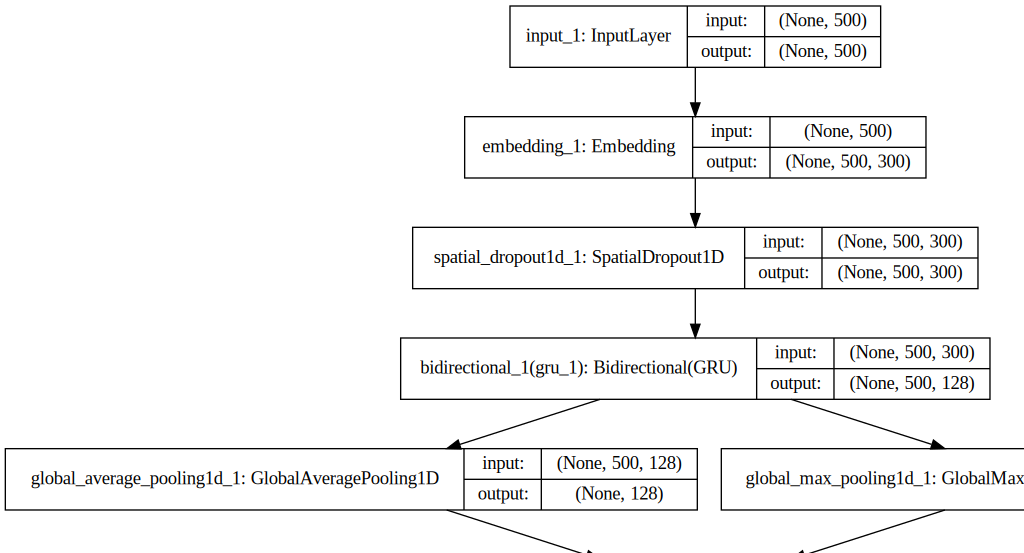

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

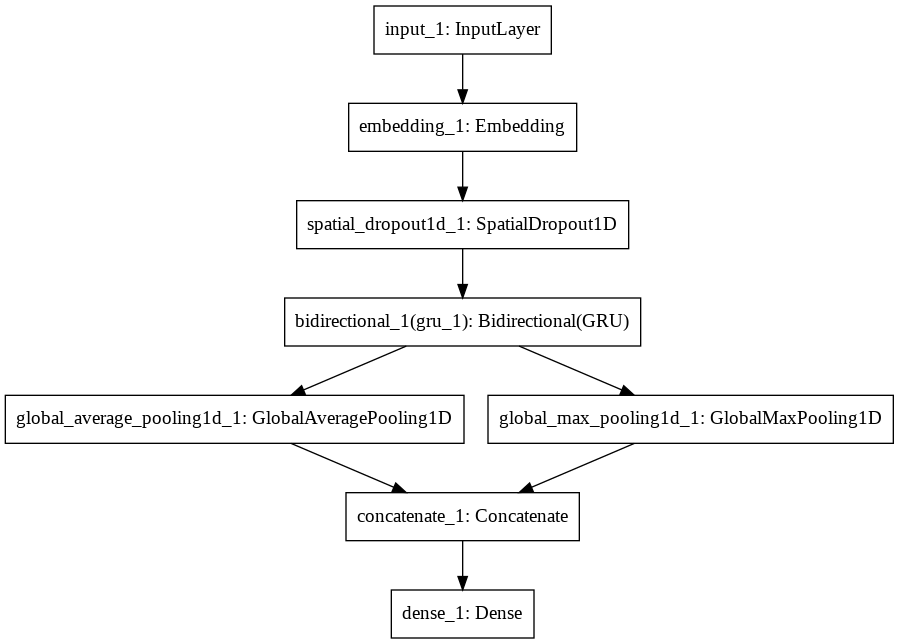

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/model.png')

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

#### Training the model

In [0]:
filepath="/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/gru_model_weights_best"
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.5
	epochs_drop = 5
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lrate =  keras.callbacks.LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1, save_best_only=True, mode='max') #only save model if it improves the accuracy
callbacks_list = [es, checkpoint]

In [0]:
epochs = 15
batch_size = 128
history = model.fit(padded_docs, labels_encoded, 
                    batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_split=0.2,
                    shuffle=True, callbacks=callbacks_list)

Train on 14823 samples, validate on 3706 samples
Epoch 1/15
14823/14823 [==============================] - 286s 19ms/step - loss: 2.0647 - accuracy: 0.4401 - val_loss: 1.8924 - val_accuracy: 0.4765
Epoch 2/15


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


14823/14823 [==============================] - 286s 19ms/step - loss: 1.8050 - accuracy: 0.4934 - val_loss: 1.7325 - val_accuracy: 0.5024
Epoch 3/15
14823/14823 [==============================] - 283s 19ms/step - loss: 1.6574 - accuracy: 0.5186 - val_loss: 1.6018 - val_accuracy: 0.5440
Epoch 4/15
14823/14823 [==============================] - 283s 19ms/step - loss: 1.5346 - accuracy: 0.5467 - val_loss: 1.5157 - val_accuracy: 0.5666
Epoch 5/15
14823/14823 [==============================] - 285s 19ms/step - loss: 1.4268 - accuracy: 0.5736 - val_loss: 1.4292 - val_accuracy: 0.5804
Epoch 6/15
14823/14823 [==============================] - 283s 19ms/step - loss: 1.3301 - accuracy: 0.5995 - val_loss: 1.3462 - val_accuracy: 0.5985
Epoch 7/15
14823/14823 [==============================] - 287s 19ms/step - loss: 1.2431 - accuracy: 0.6236 - val_loss: 1.2959 - val_accuracy: 0.6185
Epoch 8/15
14823/14823 [==============================] - 282s 19ms/step - loss: 1.1643 - accuracy: 0.6461 - val_loss

#### Evaluating model

In [0]:
preds = model.predict(padded_docs_test)
preds_train = model.predict(padded_docs)

In [0]:
preds = preds.argmax(axis=-1)
preds_train = preds_train.argmax(axis=-1)

In [0]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.57      0.80      0.67        55
           1       0.48      0.61      0.53       193
           2       0.45      0.95      0.61        44
           3       0.42      0.57      0.48        56
           4       0.54      0.57      0.55        92
           5       0.54      0.48      0.50        61
           6       0.54      0.44      0.49       194
           7       0.58      0.57      0.58        81
           8       0.41      0.82      0.55       222
          10       0.60      0.67      0.63        18
          11       0.55      0.50      0.53        42
          12       0.50      0.17      0.25        12
          13       0.60      0.80      0.68        70
          14       0.43      0.52      0.47       166
          15       0.44      0.25      0.32        72
          16       0.52      0.65      0.58        69
          17       0.29      0.14      0.19        78
          18       0.87    

In [0]:
set(preds_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [0]:
set(preds)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [0]:
scores = model.evaluate(padded_docs_test, labels_encoded_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

4633/4633 [==============================] - 24s 5ms/step
Test result: 65.271 loss: 1.082


<Figure size 432x288 with 0 Axes>

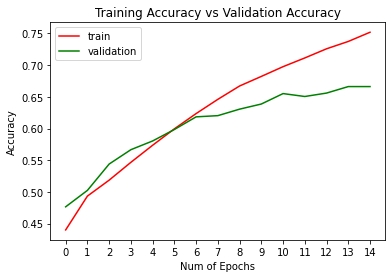

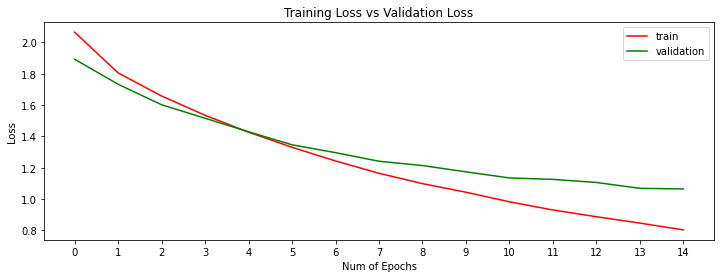

In [0]:
plt.figure(221)

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

#### Save or load models

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/gru_bidir.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/gru_bidir.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# load json and create model
json_file = open('/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/____________.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/drive/My Drive/MScA/Machine Learning/ML Final Project/Models/_______________.h5")
print("Loaded model from disk")

Loaded model from disk
